# **Transformations**

**Required Reading**

[Prince Computer Vision Chapter 15](http://www.computervisionmodels.com/)

** Relevant Documentation **
- [Camera Calibration and 3d Reconstruction](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

---

**Recommended** [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

and for presenting:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

---

- In this notebook we'll work through some geometric models for transformation
- Transformation models are useful accross many problems in computer vision, such as object tracking, image stitching, and augmented reality. 
- Let's begin by digging a bit deeper into the pinhole camera model.

In [1]:
%pylab inline
import cv2

Populating the interactive namespace from numpy and matplotlib


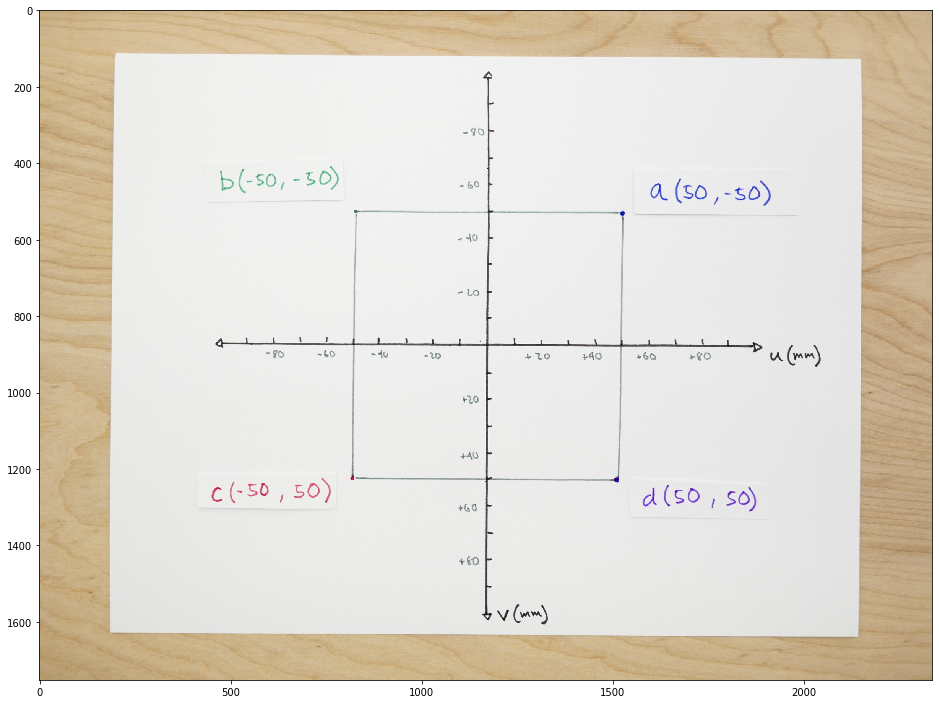

In [2]:
img = cv2.imread('../data/grids/grid_1_undistorted.jpg')

fig = figure(0, (16,16))
imshow(img[:,:,(2,1,0)])

## **What is the mathematical mapping between the coordintates of these points on the page (in mm), and their pixel locations in image space?**

- This is an undistored image taken from the camera we calibrated in the Camera Calibration notebook.
- I've measured out a coordinate grid in mm, and marked of 4 points. 
- The 3rd variable D, represents the distance between the focal point of the camera and the plane.

---

- Remember that in our discussion of the pinhole camera model, we discussed problems like this in a lot of detail, and came up with this relationship between points in image and world space:

![](../graphics/equation_summary-01.png)

- In our calibration notebook, we estimated our intrinsic matrix $\Lambda$:

In [3]:
## With a little rounding
intrinsicP = array([[2003., 0, 1161.],
                    [0, 2003., 858.],
                    [0, 0 , 1]])

- Now, to complete our mapping, we need to estimate our Extrinsic Matrix.
- Let's briefly review our coordinate system:

![](../graphics/prince/ProjectiveCamera-01.png)

----

![](../graphics/camera_setup-01.png)

- Using advanced measuring technologies, our camera optical center appears to be about 310mm above our plane.
- Now, what does this mean for our extrinsic matrix?

\begin{bmatrix}
\omega_{11} & \omega_{12} & \omega_{13} & \tau_1 \\
\omega_{21} & \omega_{22} & \omega_{23} & \tau_2 \\
\omega_{31} & \omega_{32} & \omega_{33} & \tau_3 \\
\end{bmatrix}


- Well, we've intentionally setup our camera pointing directly down towards our plane, so our rotations should be 0. Rotations of zero yield an identity rotation matrix.
- Opencv provides a nice method, [Rodrigues](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#rodrigues) that converts betwen rotation matrices and rotation vectors (roll, pitch, yaw).
- Passing in our zero rotation for this case:

In [4]:
omega, _ = cv2.Rodrigues(np.array([[0.0], [0.0], [0.0]])) #Input must be a 3x1 array of floats

In [5]:
omega

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

- Ok, so our rotation matrix is done - what about our translation values $\tau_1, \tau_2, \tau_3$?
- Well, I've done my best to position the camera optical center directly above the origin of our coordinate plane, so this should make $\tau_1, \tau_2$ close to zero. 
- Now, what about $\tau_3$?
- This term represents the distance between the optical center of our camera and our plane in the $w$ direction.
- According to our awesome measruing device, this should be around 310 mm, so $\tau_3 \approx 310$.
- Now, putting it all together:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
2003 & 0 & 1161\\
0 & 2003 & 858\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 310 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
w \\
1
\end{bmatrix}
$$

---

- Now, before we start computing, one more thing. 
- Remember that $u, v, w$ are in the coordinate frame of the plane on our piece of paper. 
- $w$ is orthogonal to our plane direction, and since our points are on our plane, this means that $w = 0$. 
- Returning to our original pinhole camera equation for a moment, this means that:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
\phi_x & 0 & \delta_x\\
0 & \phi_y & \delta_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\omega_{11} & \omega_{12} & \omega_{13} & \tau_1 \\
\omega_{21} & \omega_{22} & \omega_{23} & \tau_2 \\
\omega_{31} & \omega_{32} & \omega_{33} & \tau_3 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
0 \\
1
\end{bmatrix}
$$

- Taking advantage of the fact that $w=0$ for all points on our plane, we can simplify our equations:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
\phi_x & 0 & \delta_x\\
0 & \phi_y & \delta_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\omega_{11} & \omega_{12} & \tau_1 \\
\omega_{21} & \omega_{22} & \tau_2 \\
\omega_{31} & \omega_{32} & \tau_3 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

- Now, notice that what we're looking at here is a 2D to 2D transformation. The points on our hand-drawn plane $u, v$ are mapped to the points on our image plane $x, y$ by the equation above. 2d to 2d transformation like this are very useful in computer vision, and come in a few different varieties. We'll discuss 2d to 2d transformations at more length shortly. 


---

- Now, let's actually do some math and project the points from our hand-drawn plane to image space. 
- Combining the equations above:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
2003 & 0 & 1161\\
0 & 2003 & 858\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 310 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

- Now switching to python:

In [6]:
world_a = np.array([[50, -50, 0, 1]]).T #In homogenous coordinates
world_b = np.array([[-50, -50, 0, 1]]).T #In homogenous coordinates
world_c = np.array([[-50, 50, 0, 1]]).T #In homogenous coordinates
world_d = np.array([[50, 50, 0, 1]]).T #In homogenous coordinates

In [7]:
extrinsics_simplified = np.array([[1, 0, 0], 
                                  [0, 1, 0],
                                  [0, 0, 310.0]])

phi = np.dot(intrinsicP, extrinsics_simplified)

- Project points to image space:

In [8]:
image_a = np.dot(phi, world_a[(0, 1, 3), :])
image_a = image_a/image_a[2] #Convert homogenous to cartesian

image_b = np.dot(phi, world_b[(0, 1, 3), :])
image_b = image_b/image_b[2]

image_c = np.dot(phi, world_c[(0, 1, 3), :])
image_c = image_c/image_c[2]

image_d = np.dot(phi, world_d[(0, 1, 3), :])
image_d = image_d/image_d[2]

## **Visualize Projection**

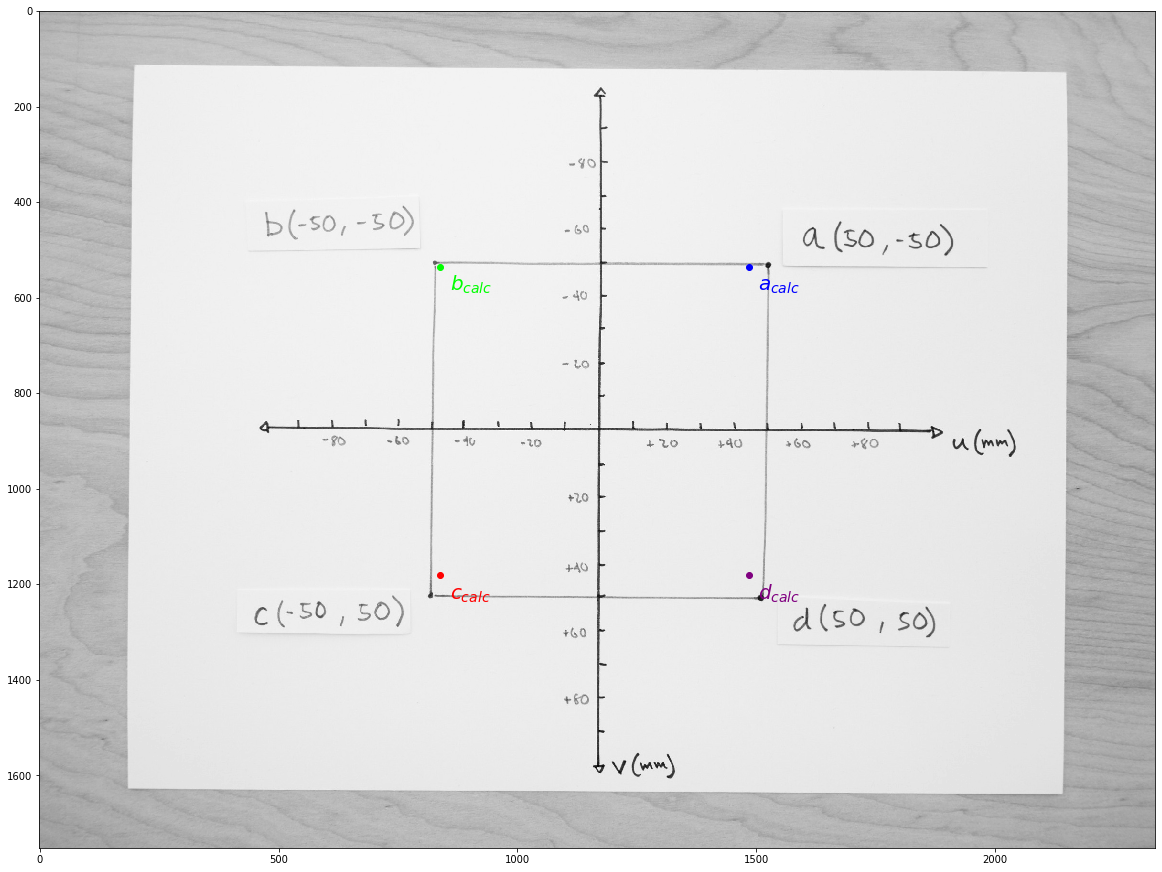

In [11]:
fig = figure(0, (20,16))
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap = 'gray')
scatter(image_a[0], image_a[1], c = [[0, 0, 1]])
text(image_a[0]+20, image_a[1]+50, '$a_{calc}$', color= (0, 0, 1), fontsize = 20);

scatter(image_b[0], image_b[1], c = [[0, 1, 0]])
text(image_b[0]+20, image_b[1]+50, '$b_{calc}$', color= (0, 1, 0), fontsize = 20);

scatter(image_c[0], image_c[1], c = [[1, 0, 0]])
text(image_c[0]+20, image_c[1]+50, '$c_{calc}$', color= (1, 0, 0), fontsize = 20);

scatter(image_d[0], image_d[1], c = [[0.5, 0, 0.5]])
text(image_d[0]+20, image_d[1]+50, '$d_{calc}$', color= (0.5, 0, 0.5), fontsize = 20);

- Alright, not perfect, but also not bad! Especially considering that we physically measured out camera position. 
- Now, there are ways to impove our projection. For one appraoch, check out [solvePnP](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#solvepnp).
- Next, let's consider a slightly more complex mapping from a plane in the world to a plane in image space.

---

## **Now With a Twist**

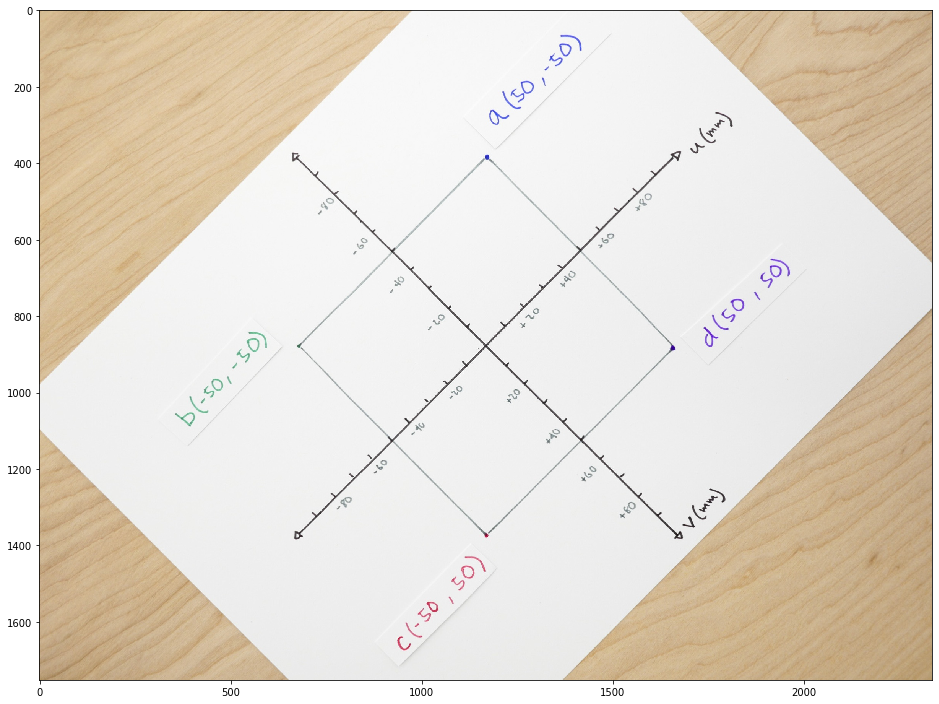

In [12]:
img = cv2.imread('../data/grids/grid_2_undistorted.jpg')

fig = figure(0, (16,16))
imshow(img[:,:,(2,1,0)])

## **What is the mathematical mapping between the coordintates of these points on the page (in mm), and their pixel locations in image space?**

- Now, what about this scenario? 
- Our camera is still directly above the origin of our hand drawn coordinate system, but know our camera has been rotated around $45^{\circ}$.
- Let's start here:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
\phi_x & 0 & \delta_x\\
0 & \phi_y & \delta_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\omega_{11} & \omega_{12} & \tau_1 \\
\omega_{21} & \omega_{22} & \tau_2 \\
\omega_{31} & \omega_{32} & \tau_3 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

- Remember that we were able to simplify our full pinhole model becuase $w=0$ for all points on our plane.
- Also, our intrinsic matrix hasn't changed, and our $\tau$ values also haven't changed.
- What has changed is our rotation.
- Let's again use the Rodrigues function

In [13]:
omega, _ = cv2.Rodrigues(np.array([[0.0], [0.0], [np.pi/4]])) #Pitch, Yaw, Roll

In [14]:
omega

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

- Note that since our camera has only "rolled", our rotation is *in the plane*. 
- The Rodrigues computation above is equivalent to rotating in the 2d coordinate system of our hand-drawn plane. 
- 2D rotations are alot simpler than 3d rotations:

$$
\begin{bmatrix}
\omega_{11} & \omega_{12}\\
\omega_{21} & \omega_{22} \\
\end{bmatrix}=
\begin{bmatrix}
cos(\theta) & - sin(\theta)\\
sin(\theta) & cos(\theta) \\
\end{bmatrix}
$$

- Not that the notation in Prince's comptuer vision is slightly different.
- Pluggin in our rotation angle of $45^{\circ}$, we obtain: 

$$
\begin{bmatrix}
\omega_{11} & \omega_{12}\\
\omega_{21} & \omega_{22} \\
\end{bmatrix}=
\begin{bmatrix}
\sqrt{2} & - \sqrt{2}\\
\sqrt{2} & \sqrt{2} \\
\end{bmatrix}
$$

- Which matches the results we computed above.

---

- Now, putting everything together:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
2003 & 0 & 1161\\
0 & 2003 & 858\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\sqrt{2} & - \sqrt{2} & 0 \\
\sqrt{2} & \sqrt{2} & 0 \\
0 & 0 & 310 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

In [15]:
theta = np.pi/4
extrinsics_simplified = np.array([[cos(theta), -sin(theta), 0], 
                                  [sin(theta), cos(theta), 0],
                                  [0, 0, 310.0]])

phi = np.dot(intrinsicP, extrinsics_simplified)

In [16]:
#Project to image space
image_a = np.dot(phi, world_a[(0, 1, 3), :])
image_a = image_a/image_a[2] #Convert homogenous to cartesian

image_b = np.dot(phi, world_b[(0, 1, 3), :])
image_b = image_b/image_b[2]

image_c = np.dot(phi, world_c[(0, 1, 3), :])
image_c = image_c/image_c[2]

image_d = np.dot(phi, world_d[(0, 1, 3), :])
image_d = image_d/image_d[2]

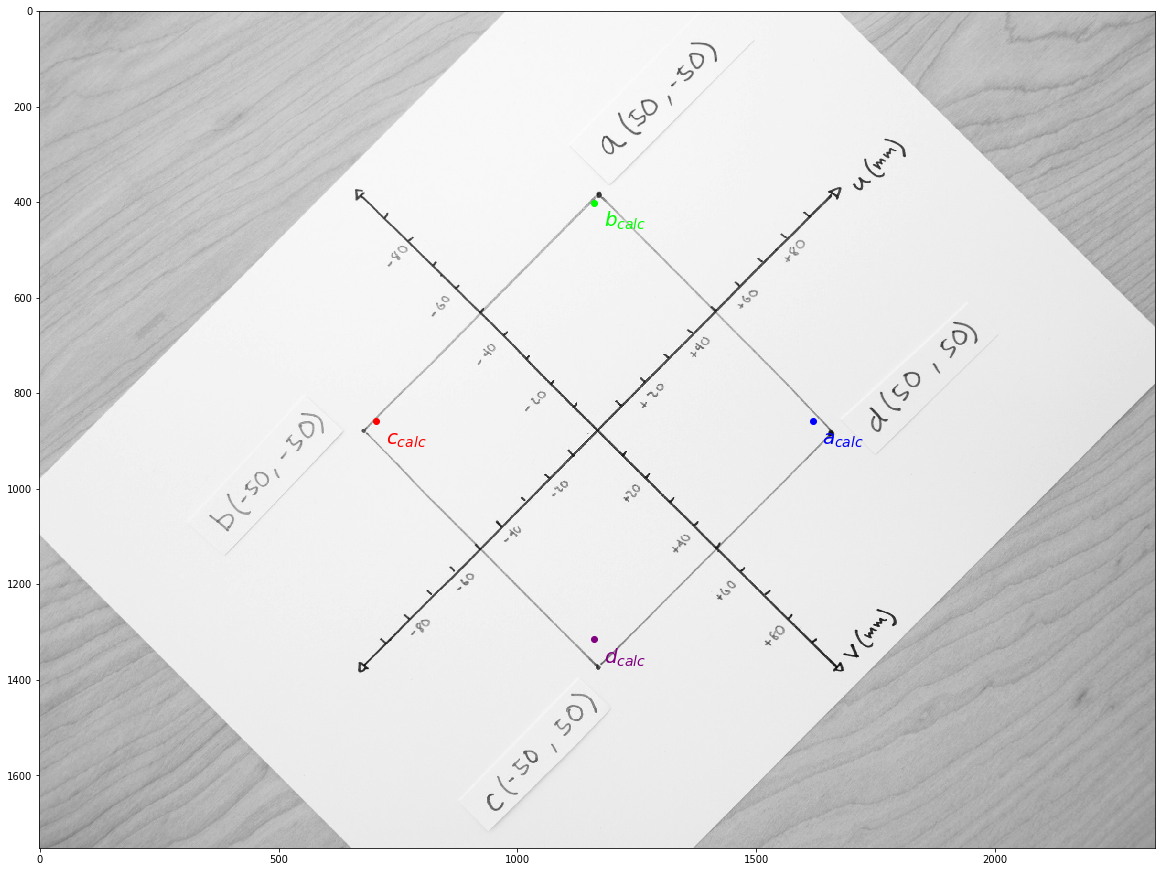

In [19]:
#And visualize
fig = figure(0, (20,16))
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap = 'gray')
scatter(image_a[0], image_a[1], c = [[0, 0, 1]])
text(image_a[0]+20, image_a[1]+50, '$a_{calc}$', color= (0, 0, 1), fontsize = 20);

scatter(image_b[0], image_b[1], c = [[0, 1, 0]])
text(image_b[0]+20, image_b[1]+50, '$b_{calc}$', color= (0, 1, 0), fontsize = 20);

scatter(image_c[0], image_c[1], c = [[1, 0, 0]])
text(image_c[0]+20, image_c[1]+50, '$c_{calc}$', color= (1, 0, 0), fontsize = 20);

scatter(image_d[0], image_d[1], c = [[0.5, 0, 0.5]])
text(image_d[0]+20, image_d[1]+50, '$d_{calc}$', color= (0.5, 0, 0.5), fontsize = 20);

- Alright! Again, not perfect, but not bad at all either. 
- This transformation from the 2d plane of the hand-drawn figure to the 2d plane of the image is called a **similarity transformation**.
- Here are the general forms of the similarity transformation model, in homogenous and cartesian coordinates:

![](../graphics/similarity_transform-01.png)

- The Similarity transform has 4 degrees of freedom: rotation angle, scale, and x and y translation.

---

## **$hit Gets Real**

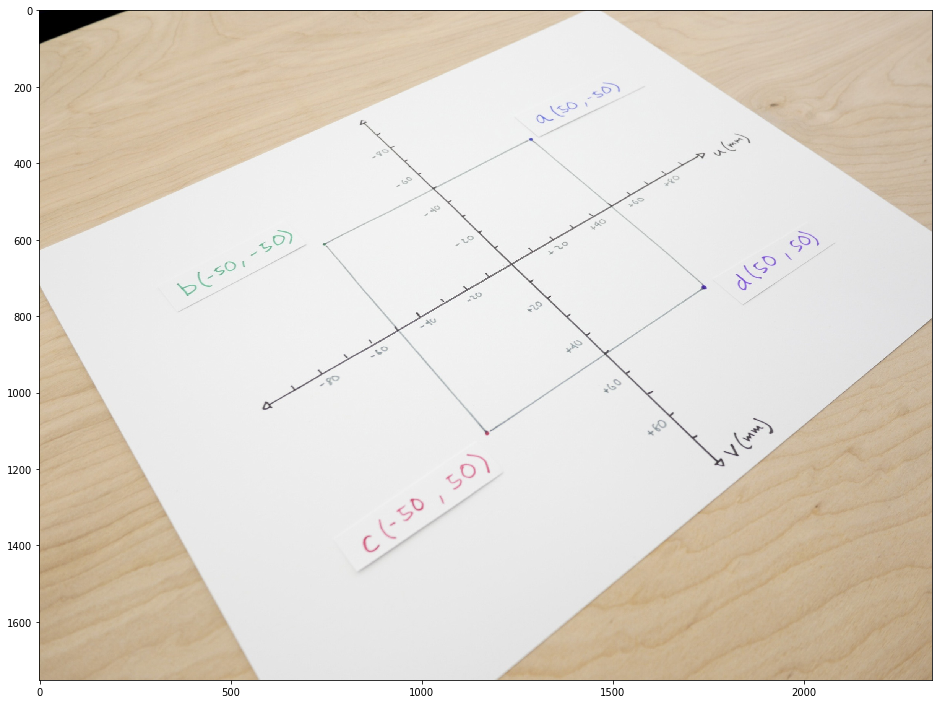

In [20]:
img = cv2.imread('../data/grids/grid_3_undistorted.jpg')

fig = figure(0, (16,16))
imshow(img[:,:,(2,1,0)])

## **What is the mathematical mapping between the coordintates of these points on the page (in mm), and their pixel locations in image space?**

![](../graphics/spacer_small-01.png)

- As you can imagine, this mapping is a little more complicated. 
- Now, even through we are at a weird angle, we're still talking about mapping between one plane and another, which means that our simplified pinhole model still applies:

$$
\lambda
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix} = 
\begin{bmatrix}
\phi_x & 0 & \delta_x\\
0 & \phi_y & \delta_y\\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\omega_{11} & \omega_{12} & \tau_1 \\
\omega_{21} & \omega_{22} & \tau_2 \\
\omega_{31} & \omega_{32} & \tau_3 \\
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

- The challenge now is estimating our extrinsics - our rotation and translation parameters. 
- Given that we know some world coordinates of the points on our hand-drawn plane and their corresponding points in image space, it is possible to solve for the translation and rotation of our camera. Check out opencv's [solvePnP](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#solvepnp) for more details.
- Here we're going to take a bit of shortcut that will take us to the most general plane-to-plane transformation.

![](../graphics/homography_transform-01.png)

- Homographies are the most general 2d to 2d class of transformation, and perfectly describe the transormation between the points on an arbitrary plane in world space and their positions after being projected to the image plane. 
- Given a set of corresponding points, we can compute a homography matrix using opencv's `findHomography`.
- To do this, we first need the pixel locations of points a, b, c, and d in our image. 
- There's a bunch of ways to get these, personally, I just plot the image in an external window using `pylab qt`, the python plotter will diplay the pixel location of your mouse in the bottom left corner. I just hover my mouse of the relevant points and record their values. 
- pylab qt can be a little finicky (I always have to run it twice!), just google around for python plotting without using the notebook for other options.

---

In [21]:
#Pops plots out of the notebook
# %pylab qt

In [22]:
# fig = figure(0, (16,16))
# imshow(img[:,:,(2,1,0)])

In [23]:
#Points picked off from image - a, b, c, d in order
image_points = np.array([[1291.8, 340.5],
                         [747.5, 613.6], 
                         [1176.3, 1108.8],
                         [1743.3, 729.1]])

---

In [24]:
#Plot back in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
world_points = np.vstack((world_a[:2, :].T, world_b[:2, :].T, world_c[:2, :].T, world_d[:2, :].T))

In [26]:
world_points

array([[ 50, -50],
       [-50, -50],
       [-50,  50],
       [ 50,  50]])

- Compute homography using opencv:

In [27]:
phi, _ = cv2.findHomography(world_points, image_points)

In [28]:
#Project to image space
image_a = np.dot(phi, world_a[(0, 1, 3), :])
image_a = image_a/image_a[2] #Convert homogenous to cartesian

image_b = np.dot(phi, world_b[(0, 1, 3), :])
image_b = image_b/image_b[2]

image_c = np.dot(phi, world_c[(0, 1, 3), :])
image_c = image_c/image_c[2]

image_d = np.dot(phi, world_d[(0, 1, 3), :])
image_d = image_d/image_d[2]

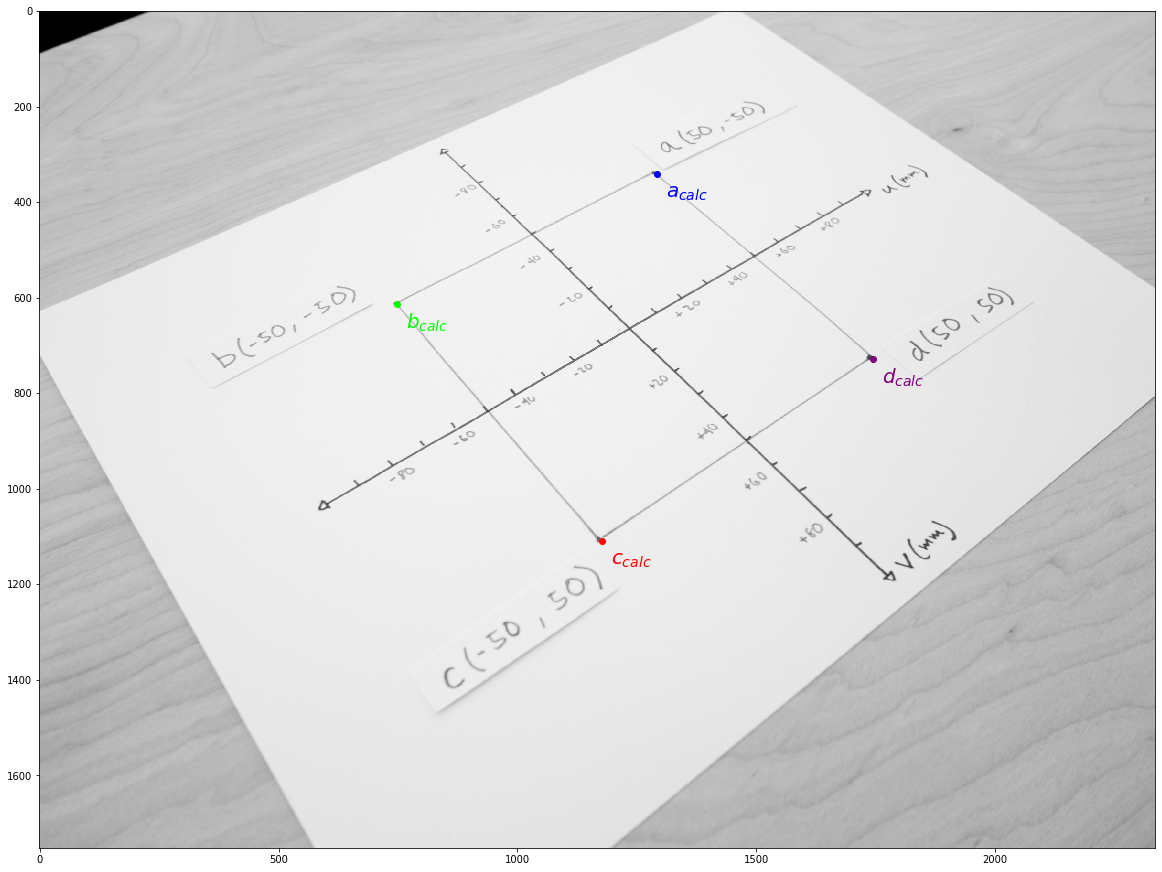

In [29]:
#And visualize
fig = figure(0, (20,16))
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap = 'gray')
scatter(image_a[0], image_a[1], c = [[0, 0, 1]])
text(image_a[0]+20, image_a[1]+50, '$a_{calc}$', color= (0, 0, 1), fontsize = 20);

scatter(image_b[0], image_b[1], c = [[0, 1, 0]])
text(image_b[0]+20, image_b[1]+50, '$b_{calc}$', color= (0, 1, 0), fontsize = 20);

scatter(image_c[0], image_c[1], c = [[1, 0, 0]])
text(image_c[0]+20, image_c[1]+50, '$c_{calc}$', color= (1, 0, 0), fontsize = 20);

scatter(image_d[0], image_d[1], c = [[0.5, 0, 0.5]])
text(image_d[0]+20, image_d[1]+50, '$d_{calc}$', color= (0.5, 0, 0.5), fontsize = 20);

- Pretty good, right?
- Now, if you may be a bit skeptical here - of course we mapped those 4 points correctly, we fed them directly into our homography calculation!
- This is a good point, let's look at one more cool thing we can do with the homography we just computed that will hopefully convince you that it's a good representation of the mapping between our world and image planes.

---

- Among other things, we can use homographies to warp the perspective of images of planar objects. 
- Using the homography we just computed, we can map our oblique image to an "overhead" view.

In [30]:
#Two switch the direction of our mapping, we just invert our homography matrix:
phi_inv = np.linalg.inv(phi)

In [31]:
# This part is a little annoying/technical. 
# Basically, I'm shifting our homography around to increase the 
# resolution of our mapped image, and let it appear totally "in frame"
# This is a result of the fact that our image coordiate systems origin is in the upper left, 
# and that our hand-drawn plane origin is in the center of our image

scale = 8
Tx = img.shape[1]/2
Ty = img.shape[0]/2
N = np.array([[scale, 0, Tx], 
              [0, scale, Ty], 
              [0, 0, 1]])

In [32]:
adjusted_homography = np.dot(N, phi_inv)

In [33]:
warped = cv2.warpPerspective(img, adjusted_homography, (img.shape[1], img.shape[0]))

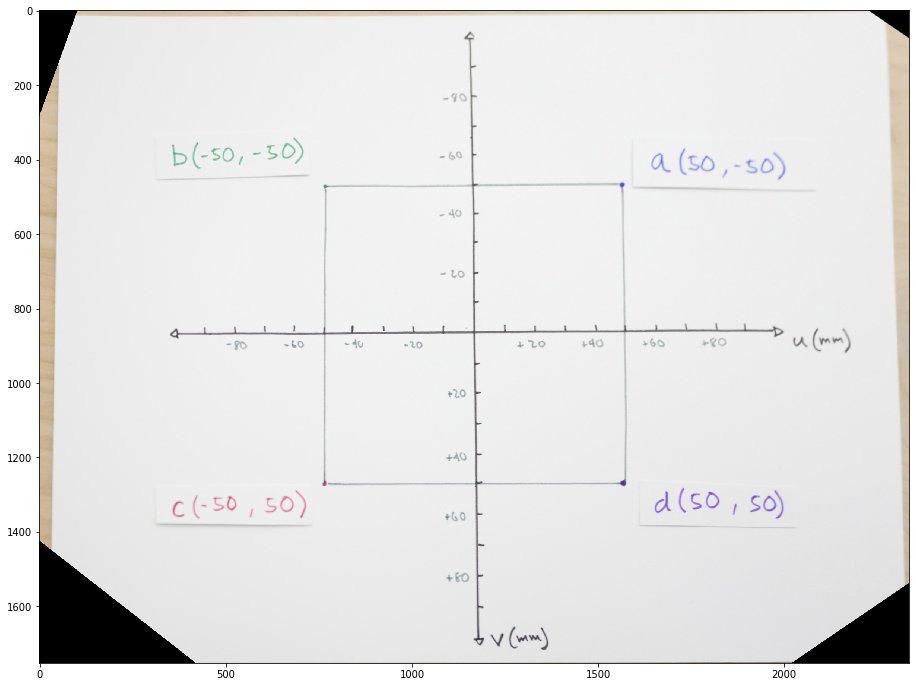

In [34]:
fig = figure(0, (18,12))
imshow(warped[:,:,(2,1,0)])

- Check it out! Using our homography, we've warped our image to an overhead view!
- This trick is very useful in autonmous driving, allowing us to warp images of the road to a "bird's eye" view. 

---

## **Wrapping Up**

![](../graphics/transformation_models_summary-01.png)

- We discussed 2 of these transformations in detail, the similarity and projective/homography transformation. 
- All of these transformations can be derived from the pinhole camera model - this is the appoach Simon Prince takes in chapter 15 of this terrific computer vision book. 
- Homographies are the most general transformation we discussed, and describe the mapping between:

1. Points on any plane in the world and their positions in an image
2. Points in two different images of the same plane
3. Two images of a 3D object where the camera has rotated by not translated

----